### BCCD Dataset(VOC 타입)를 COCO 형태로 바꾸고, 이 COCO형태의 데이터를 다시 YOLO data format으로 바꾸어, UltraLytics Yolo v5를 이용해 train하는 실습을 할 것이다

In [1]:
# Ultralytics YOLO v5 다운로드 하기
# 다운로드하면 yolov5라는 디렉토리가 생성된다
!git clone https://github.com/ultralytics/yolov5

# Requirement를 보면 Ultralytics YOLO v3와 거의 비슷하다
!cd yolov5;pip install -qr requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 12074, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 12074 (delta 10), reused 23 (delta 9), pack-reused 12047
Receiving objects: 100% (12074/12074), 12.48 MiB | 10.96 MiB/s, done.
Resolving deltas: 100% (8301/8301), done.
     |████████████████████████████████| 1.6 MB 41.6 MB/s 


### XML 포맷의 BCCD 데이터 세트를 다운로드 후 voc2coco를 이용하여 ms-coco 형태로 변환
* BCCD는 VOC형태의 데이터이다 : 하나의 이미지 당 하나의 annotation파일
* 하지만 COCO는 이와 달리 train/val/test annotation이렇게 3개의 ann파일이 있고, 여러 장의 이미지에 대한 정보가 저장되어 있다
* voc2coco 유틸리티를 이용하면 매우 쉽게 voc를 coco형태로 변환할 수 있다

In [2]:
import os

# BCCD Dataset 다운로드
!git clone https://github.com/Shenggan/BCCD_Dataset.git

# voc2coco utility다운로드
!git clone https://github.com/yukkyo/voc2coco.git

# voc2coco manual에 다음과 같이 사용하라고 나와있다
# colab 버전은 아래 명령어로 BCCD의 labels.txt를 생성,
# 존재하는 모든 class들을 다음과 같이 입력한다 
with open('/content/BCCD_Dataset/BCCD/labels.txt', "w") as f:
    f.write("WBC\n")
    f.write("RBC\n")
    f.write("Platelets\n")

# labels.txt 출력 해보기
!cat /content/BCCD_Dataset/BCCD/labels.txt

# VOC를 COCO로 변환 수행. 학습/검증/테스트 용 json annotation을 생성. 
# train dataset에 대한 annotation파일인 train.json생성
%cd voc2coco
!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/train.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/train.json \
--ext xml

# validation dataset에 대한 annotation파일인 val.json생성
!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/val.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/val.json \
--ext xml

# test dataset에 대한 annotation파일인 test.json생성
!python voc2coco.py --ann_dir /content/BCCD_Dataset/BCCD/Annotations \
--ann_ids /content/BCCD_Dataset/BCCD/ImageSets/Main/test.txt \
--labels /content/BCCD_Dataset/BCCD/labels.txt \
--output /content/BCCD_Dataset/BCCD/test.json \
--ext xml

# annotation json 파일을 가독성 있게 열람할 수 있도록 jq 유틸리티를 다음과 같이 사용한다 
!sudo apt-get install jq
!jq . /content/BCCD_Dataset/BCCD/train.json > output.json
# 뒷부분 100줄 출력
!tail -100 output.json

Cloning into 'BCCD_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800
Receiving objects: 100% (800/800), 7.39 MiB | 7.97 MiB/s, done.
Resolving deltas: 100% (378/378), done.
Cloning into 'voc2coco'...
remote: Enumerating objects: 436, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 436 (delta 11), reused 19 (delta 6), pack-reused 409
Receiving objects: 100% (436/436), 216.32 KiB | 16.64 MiB/s, done.
Resolving deltas: 100% (387/387), done.
WBC
RBC
Platelets
/content/voc2coco
Start converting !
100% 205/205 [00:00<00:00, 4591.92it/s]
Start converting !
100% 87/87 [00:00<00:00, 5686.08it/s]
Start converting !
100% 72/72 [00:00<00:00, 5520.94it/s]
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autor

In [3]:
# working directory를 /content로 재 지정
%cd /content

/content


In [4]:
!git clone https://github.com/alexmihalyk23/COCO2YOLO.git

Cloning into 'COCO2YOLO'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 63 (delta 25), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (63/63), done.


### COCO 포맷을 Ultralytics yolo 포맷으로 변환
* https://github.com/alexmihalyk23/COCO2YOLO.git 를 약간 수정하여 변환 logic을 생성할 것이다

* 소스 이미지 디렉토리와 Json annotation 파일, 타겟 이미지 디렉토리, 타겟 annotation 디렉토리를 기반으로 train/val/test Json annotation 파일에 따라 **소스 이미지 디렉토리에 있는 파일들은 타겟 이미지 디렉토리로 단순 복사**하고, **annotation 파일은 yolo 포맷으로 변환하여 타겟 annotation 디렉토리로 저장**할 것이다
* **한 개의 json annotation 파일이 여러개의 yolo 포맷 annotation 파일로 변환**된다

In [5]:
# 결국 우리가 재 구성해야 할 최종 Directory는 다음과 같다
# bccd/images/train : 학습용 이미지 파일
# bccd/images/val : 평가용 이미지 파일
# bccd/images/test : 최종 평가용 이미지 파일

# bccd/labels/train : 학습용 이미지 annotation 파일
# bccd/labels/val : 평가용 이미지 annotation 파일
# bccd/labels/test : 최종 평가용 이미지 annotation 파일

### 아래 json annotation 파일 형식을 보면 어떤 식으로 처리하는지 쉽게 알 수 있다.
### annotations파일에는
Images키(파일의 기본 정보), annotations키(BBox정보, 클래스 정보..)..등 여러가지 키가 존재한다

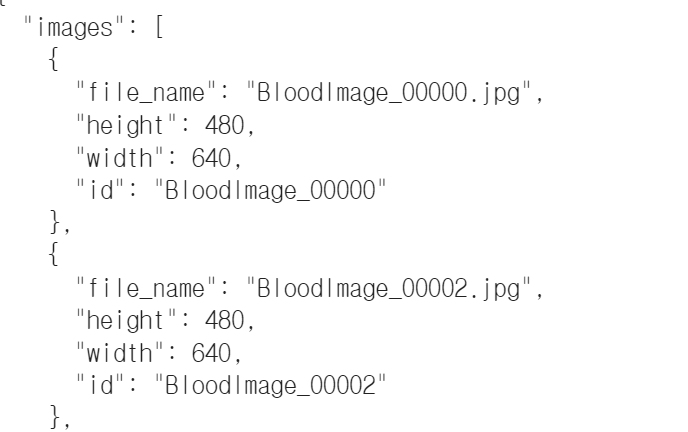

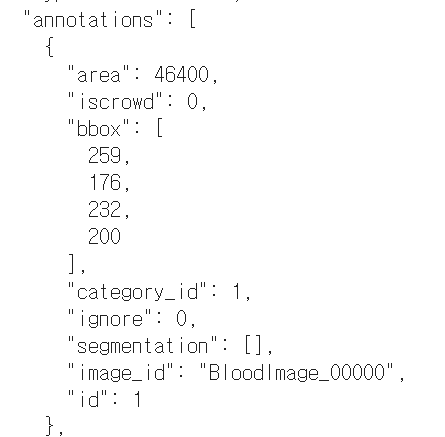

In [6]:
# https://github.com/alexmihalyk23/COCO2YOLO.git
import json
import os
import shutil

class COCO2YOLO:
  # 소스 이미지 디렉토리와 Json annotation 파일, 타겟 이미지 디렉토리, 타겟 annotation 디렉토리를 생성자로 입력 받음. 
  def __init__(self, src_img_dir, json_file, tgt_img_dir, tgt_anno_dir):
    self.json_file = json_file
    self.src_img_dir = src_img_dir
    self.tgt_img_dir = tgt_img_dir
    self.tgt_anno_dir = tgt_anno_dir

    # json 파일과 타겟 디렉토리가 존재하는지 확인하고, 디렉토리의 경우는 없으면 생성. 
    self._check_file_and_dir(json_file, tgt_img_dir, tgt_anno_dir)

    # annotation파일을 메모리로 로딩. 
    self.labels = json.load(open(json_file, 'r', encoding='utf-8'))

    # category id와 이름을 매핑하지만, 실제 class id는 이를 적용하지 않고 별도 적용. 
    self.coco_id_name_map = self._categories()
    self.coco_name_list = list(self.coco_id_name_map.values())
    print("total images", len(self.labels['images']))
    print("total categories", len(self.labels['categories']))
    print("total labels", len(self.labels['annotations']))
  
  # json 파일과 타겟 디렉토리가 존재하는지 확인하고, 디렉토리의 경우는 없으면 생성
  # json파일이 존재하지 않는다면 parsing자체가 불가하므로 Error발생
  def _check_file_and_dir(self, file_path, tgt_img_dir, tgt_anno_dir):
    if not os.path.exists(file_path):
        raise ValueError("file not found")

    # Target Directory(Image가 들어갈 곳)가 존재하지 않는다면 Directory를 만든다
    if not os.path.exists(tgt_img_dir):
        os.makedirs(tgt_img_dir)

    # Target Directory(Annotation파일이 들어갈 곳)가 존재하지 않는다면 Directory를 만든다
    if not os.path.exists(tgt_anno_dir):
        os.makedirs(tgt_anno_dir)

  # category id와 이름을 매핑하지만, 추후에 class 명만 활용. 
  def _categories(self):
    categories = {}
    for cls in self.labels['categories']:
        categories[cls['id']] = cls['name']
    return categories
  
  # annotation에서 모든 image의 파일명(절대 경로 아님)과 width, height 정보 저장. 
  def _load_images_info(self):
    images_info = {}
    for image in self.labels['images']:
        id = image['id'] # BloodImage_00000
        file_name = image['file_name'] # BloodImage_00000.jpg
        if file_name.find('\\') > -1:
            file_name = file_name[file_name.index('\\')+1:]
        w = image['width'] # 480
        h = image['height'] # 640 
        # w와 h는 나중에 정규화를 위하여 필요하다
        images_info[id] = (file_name, w, h)
        
        # 그래서 최종적으로 다음과 같은 dictionary를 반환한다.
        # images_info = {
        #   "BloodImage_00000" : ("BloodImage_00000.jpg", 480, 640),
        #   "BloodImage_00001" : ("BloodImage_00001.jpg", 480, 640),                  
        #         ... 
        #         }

    return images_info

  # ms-coco의 bbox annotation은 yolo format으로 변환. 
  # 좌상단 x, y좌표, width, height 기반을 정규화된 center x,y 와 width, height로 변환. 
  def _bbox_2_yolo(self, bbox, img_w, img_h):
    # ms-coco는 좌상단 x, y좌표, width, height
    x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]

    # center x좌표는 좌상단 x좌표에서 width의 절반을 더함. center y좌표는 좌상단 y좌표에서 height의 절반을 더함.  
    centerx = bbox[0] + w / 2
    centery = bbox[1] + h / 2

    # centerx, centery, width, height를 이미지의 width/height로 정규화. 
    dw = 1 / img_w
    dh = 1 / img_h
    centerx *= dw
    w *= dw
    centery *= dh
    h *= dh
    return centerx, centery, w, h
  
    # images_info = {
    #   "BloodImage_00000" : ("BloodImage_00000.jpg", 480, 640),
    #   "BloodImage_00001" : ("BloodImage_00001.jpg", 480, 640),                  
    #         ... 
    #         }
  # image와 annotation파일 정보를 기반으로 image명과 yolo annotation 정보 가공하여서 
  # 개별 image당 하나의 annotation 정보를 가지도록 변환하는 함수이다
  def _convert_anno(self, images_info):
    anno_dict = dict()

    # 모든 이미지에 존재하는 모든 BBox정보들을 anno_dict라는 곳에 집어넣을 것이다
    for anno in self.labels['annotations']:
      bbox = anno['bbox'] # 해당 이미지 내에 존재하는 BBox 좌표 네 개
      image_id = anno['image_id'] # "BloodImage_00000"
      category_id = anno['category_id'] # 해당 bbox의 object 클래스 의미

      image_info = images_info.get(image_id) # ("BloodImage_00000.jpg", 480, 640)반환
      image_name = image_info[0] # image_name : "BloodImage_00000.jpg"
      img_w = image_info[1] # 480
      img_h = image_info[2] # 640
      yolo_box = self._bbox_2_yolo(bbox, img_w, img_h) # yolo data format의 BBox형식으로 바꾸어준다

      anno_info = (image_name, category_id, yolo_box) # (("BloodImage_00000",1,(0.2,0.4,100,240)),1,(0.2,0.4,100,240)) 이런 식으로 나온다
      anno_infos = anno_dict.get(image_id) # 해당 이미지 내에 존재하는

      # 만약 "BloodImage_0000"파일에 대한 정보가 아직 anno_infos에 없다면
      if not anno_infos:
        anno_dict[image_id] = [anno_info]
      # 이미 등재되어 있다면
      else:
        anno_infos.append(anno_info)
        anno_dict[image_id] = anno_infos
    return anno_dict
# 다음과 같은 식으로 반환된다
# {
#    "BloodImage_00000" : ("BloodImage_00000",1,(0.2,0.4,100,240)])
#    "BloodImage_00001" : ("BloodImage_00001",2,(0.3,0.3,120,200)])
# }


  # class 명을 파일로 저장하는 로직. 사용하지 않음. 
  def save_classes(self):
    sorted_classes = list(map(lambda x: x['name'], sorted(self.labels['categories'], key=lambda x: x['id'])))
    print('coco names', sorted_classes)
    with open('coco.names', 'w', encoding='utf-8') as f:
      for cls in sorted_classes:
          f.write(cls + '\n')
    f.close()
  # _convert_anno(images_info)로 만들어진 anno 정보를 개별 yolo anno txt 파일로 생성하는 로직. 
  # coco2yolo()에서 anno_dict = self._convert_anno(images_info)로 만들어진 anno_dict를 _save_txt()에 입력하여 파일 생성
  def _save_txt(self, anno_dict):
    # 개별 image별로 소스 image는 타겟이미지 디렉토리로 복사하고, 개별 annotation을 타겟 anno 디렉토리로 생성. 
    for k, v in anno_dict.items():
      # 소스와 타겟 파일의 절대 경로 생성. 
      src_img_filename = os.path.join(self.src_img_dir, v[0][0])
      tgt_anno_filename = os.path.join(self.tgt_anno_dir,v[0][0].split(".")[0] + ".txt")
      #print('source image filename:', src_img_filename, 'target anno filename:', tgt_anno_filename)
      
      # 이미지 파일의 경우 타겟 디렉토리로 단순 복사. 
      shutil.copy(src_img_filename, self.tgt_img_dir)
      
      # 타겟 annotation 출력 파일명으로 classid, bbox 좌표를 object 별로 생성. 
      with open(tgt_anno_filename, 'w', encoding='utf-8') as f:
        # print(k, v)
        # 여러개의 object 별로 classid와 bbox 좌표를 생성. 
        for obj in v:
          cat_name = self.coco_id_name_map.get(obj[1])
          # category_id는 class 명에 따라 0부터 순차적으로 부여. 
          category_id = self.coco_name_list.index(cat_name)
          #print('cat_name:', cat_name, 'category_id:', category_id)
          box = ['{:.6f}'.format(x) for x in obj[2]]
          box = ' '.join(box)
          line = str(category_id) + ' ' + box
          f.write(line + '\n')

  # ms-coco를 yolo format으로 변환. 
  def coco2yolo(self):
    print("loading image info...")
    images_info = self._load_images_info()
    print("loading done, total images", len(images_info))

    print("start converting...")
    anno_dict = self._convert_anno(images_info)
    print("converting done, total labels", len(anno_dict))

    print("saving txt file...")
    self._save_txt(anno_dict)
    print("saving done")

In [7]:
# jq utility를 이용하여 가독성 있는 json파일로 만들어주고 출력
!jq . /content/BCCD_Dataset/BCCD/val.json > output_val.json
!cat output_val.json

{
  "images": [
    {
      "file_name": "BloodImage_00000.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00000"
    },
    {
      "file_name": "BloodImage_00002.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00002"
    },
    {
      "file_name": "BloodImage_00014.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00014"
    },
    {
      "file_name": "BloodImage_00017.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00017"
    },
    {
      "file_name": "BloodImage_00028.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00028"
    },
    {
      "file_name": "BloodImage_00029.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00029"
    },
    {
      "file_name": "BloodImage_00030.jpg",
      "height": 480,
      "width": 640,
      "id": "BloodImage_00030"
    },
    {
      "file_name": "BloodImage_00035.jpg",
      "height": 480,
      "width": 640

In [8]:
# 학습/검증/테스트용 images, labels 디렉토리 생성. 
!mkdir /content/bccd;
!cd /content/bccd; mkdir images; mkdir labels;
!cd /content/bccd/images; mkdir train; mkdir val; mkdir test
!cd /content/bccd/labels; mkdir train; mkdir val; mkdir test

In [9]:
# train 용 yolo 데이터 세트 생성. 
train_yolo_converter = COCO2YOLO(src_img_dir='/content/BCCD_Dataset/BCCD/JPEGImages', json_file='/content/BCCD_Dataset/BCCD/train.json',
                                 tgt_img_dir='/content/bccd/images/train', tgt_anno_dir='/content/bccd/labels/train')
train_yolo_converter.coco2yolo()

# val 용 yolo 데이터 세트 생성. 
val_yolo_converter = COCO2YOLO(src_img_dir='/content/BCCD_Dataset/BCCD/JPEGImages', json_file='/content/BCCD_Dataset/BCCD/val.json',
                                 tgt_img_dir='/content/bccd/images/val', tgt_anno_dir='/content/bccd/labels/val')
val_yolo_converter.coco2yolo()

# test 용 yolo 데이터 세트 생성. 
test_yolo_converter = COCO2YOLO(src_img_dir='/content/BCCD_Dataset/BCCD/JPEGImages', json_file='/content/BCCD_Dataset/BCCD/test.json',
                                 tgt_img_dir='/content/bccd/images/test', tgt_anno_dir='/content/bccd/labels/test')
test_yolo_converter.coco2yolo()

total images 205
total categories 3
total labels 2805
loading image info...
loading done, total images 205
start converting...
converting done, total labels 205
saving txt file...
saving done
total images 87
total categories 3
total labels 1138
loading image info...
loading done, total images 87
start converting...
converting done, total labels 87
saving txt file...
saving done
total images 72
total categories 3
total labels 945
loading image info...
loading done, total images 72
start converting...
converting done, total labels 72
saving txt file...
saving done


### Dataset용 yaml 파일을 생성하고 학습 수행
* yolo v5는 모델이 yolov5s(small), yolov5m(middle), yolov5l(large), yolov5x(extra large)로 되어있음. weight 인자값으로 이들중 하나를 입력해 줌

In [10]:
# yaml파일에는 방금 만든 Directory대로 config가 설정되어 있다
!wget -O /content/bccd/bccd.yaml https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/bccd.yaml

--2022-08-29 13:44:23--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/util/bccd.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 184 [text/plain]
Saving to: ‘/content/bccd/bccd.yaml’

/content/bccd/bccd. 100%[===================>]     184  --.-KB/s    in 0s      

2022-08-29 13:44:23 (10.5 MB/s) - ‘/content/bccd/bccd.yaml’ saved [184/184]



In [11]:
# Google Drive 접근을 위한 Mount 적용. 
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [12]:
# soft link로 Google Drive Directory 연결. 
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive
# Google Drive 밑에 Directory 생성. 이미 생성 되어 있을 시 오류 발생. 
!mkdir "/mydrive/ultra_workdir"

'작물 잎 사진 질병 분류 프로젝트'      'patchdata (1).py'
 설문지				        patchdata.py
 AlexNet.ipynb			        pet_work_dir
 Chapter_1			       'pix2pix (2016).ipynb'
'Colab Notebooks'		       'PreAct-ResNet (2016).ipynb'
'Conditional GAN_(2014).ipynb'	       'Python OpenCV.ipynb'
 dataset			       'ResNet (2015).py'
'DCGAN (2015).ipynb'		       'ResNext (2017).ipynb'
'deep learning'			        Selfie2anime.ipynb
'DenseNet_(2017).ipynb'		       'Seq2Seq (2014).ipynb'
 DLCV				       'SRCNN (2014).ipynb'
'ESPCN_(2016).ipynb'		       'Style Transfer (2015).ipynb'
'GAN (2014).ipynb'		        test.py
'GoogLeNet (2014)'		       'Transformer (2017).ipynb'
'GoogLeNet(2014).ipynb'		        ultra_workdir
'Inceptionv4(2016).ipynb'	        VGGNet
 input.zip			        VisionTransformer
'Knowledge Distillation (2014).ipynb'   vit
 LeNet-5.ipynb			        vit.ipynb
'MobileNet_(2017).ipynb'	       'Wide ResNet(2016).ipynb'
 model				       'Xception_(2017).ipynb'
 model.py
mkdir: cannot 

In [13]:
###  10번 미만 epoch는 좋은 성능이 안나옴. 최소 30번 이상 epoch 적용. large 모델 적용 시 batch size가 8보다 클 경우 colab에서 memory 부족 발생.
### --weights로 전달된 모델이 존재하지 않는다면 자동으로 다운로드 받는다
### 혈소판의 경우 상대적으로 mAP:0.5~0.95 Detection 성능이 좋지 못함. 백혈구 만큼 학습데이터가 적은것도 이유지만, Object 사이즈가 상대적으로 작음.   
!cd /content/yolov5; python train.py --img 640 --batch 8 --epochs 30 --data /content/bccd/bccd.yaml --weights yolov5l.pt \
                                     --project=/mydrive/ultra_workdir --name bccd --exist-ok 

train: weights=yolov5l.pt, cfg=, data=/content/bccd/bccd.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=/mydrive/ultra_workdir, name=bccd, exist_ok=True, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-69-gfef1913 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, 

In [ ]:
# train데이터의 class 분포를 확인해보자
from collections import Counter

anno_list = train_yolo_converter.labels['annotations']
category_list = [x['category_id'] for x in anno_list]

Counter(category_list)

Counter({1: 214, 2: 2382, 3: 209})

### 단일 이미지 inference 수행 및 테스트 데이터 세트 evaluation

In [14]:
# image 파일 inference
## --source : target image
!cd /content/yolov5;python detect.py --source /content/bccd/images/test/BloodImage_00011.jpg \
                            --weights /mydrive/ultra_workdir/bccd/weights/best.pt --conf 0.2 \
                            --project=/content/data/output --name=run_image --exist-ok --line-thickness 2

detect: weights=['/mydrive/ultra_workdir/bccd/weights/best.pt'], source=/content/bccd/images/test/BloodImage_00011.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.2, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/content/data/output, name=run_image, exist_ok=True, line_thickness=2, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.2-69-gfef1913 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 367 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
image 1/1 /content/bccd/images/test/BloodImage_00011.jpg: 480x640 1 WBC, 17 RBCs, 1 Platelets, 43.1ms
Speed: 0.5ms pre-process, 43.1ms inference, 1.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to /content/data/output/run_image


In [18]:
# test dataset에 적용하여 결과를 확인하기
!cd /content/yolov5; python val.py --weights /mydrive/ultra_workdir/bccd/weights/best.pt  --data /content/bccd/bccd.yaml \
                           --project /content/data/output --name=test_result --exist-ok --img 640 --iou 0.65


val: data=/content/bccd/bccd.yaml, weights=['/mydrive/ultra_workdir/bccd/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=/content/data/output, name=test_result, exist_ok=True, half=False, dnn=False
YOLOv5 🚀 v6.2-69-gfef1913 Python-3.7.13 torch-1.12.1+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 367 layers, 46119048 parameters, 0 gradients, 107.7 GFLOPs
val: Scanning '/content/bccd/labels/val.cache' images and labels... 87 found, 0 missing, 0 empty, 0 corrupt: 100% 87/87 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R     mAP@.5 mAP@.5:.95: 100% 3/3 [00:04<00:00,  1.62s/it]
                   all         87       1138       0.87      0.892      0.918       0.64
                   WBC         87         87      0.978          1       0.99      0.8